Benjamin Ye  
CS/CNE/EE 156a: Learning Systems (Fall 2023)  
December 1, 2023

## Final Exam

In [1]:
import sys

from cvxopt import matrix, solvers
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn import svm

mpl.rcParams.update(
    {
        "axes.labelsize": 14,
        "figure.autolayout": True,
        "figure.figsize": (4.875, 3.65625),
        "font.size": 12,
        "legend.columnspacing": 1,
        "legend.edgecolor": "1",
        "legend.framealpha": 0,
        "legend.fontsize": 12,
        "legend.handlelength": 1.25,
        "legend.labelspacing": 0.25,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "text.usetex": True
    }
)

CWD = globals()['_dh'][0]
sys.path.insert(0, str(CWD.parent))
from cs156a import (LinearRegression, RBFRegular,
                    target_function_final_exam, generate_data, validate_binary)

DATA_DIR = CWD.parent / "data"

rng = np.random.default_rng()

### Problems 7–10

In [2]:
DATA_DIR.mkdir(exist_ok=True)
data = {}
for dataset in ["train", "test"]:
    file = f"features.{dataset}"
    if not (DATA_DIR / file).exists():
        r = requests.get(f"http://www.amlbook.com/data/zip/{file}")
        with open(DATA_DIR / file, "wb") as f:
            f.write(r.content)
    data[dataset] = np.loadtxt(DATA_DIR / file)

weight_decay_lambda = 1
transform = lambda x: np.hstack((x, x[:, 1:2] * x[:, 2:], x[:, 1:2] ** 2, 
                                 x[:, 2:] ** 2))
reg = LinearRegression(vf=validate_binary, regularization="weight_decay", 
                       weight_decay_lambda=weight_decay_lambda)
reg_transform = LinearRegression(vf=validate_binary,
                                 regularization="weight_decay", 
                                 transform=transform,
                                 weight_decay_lambda=weight_decay_lambda)
df = pd.DataFrame(columns=["classifier", "in-sample error",
                           "out-of-sample error",
                           "transform in-sample error",
                           "transform out-of-sample error"])
for digit in range(10):
    x_train = np.hstack((np.ones((len(data["train"]), 1), dtype=float), 
                         data["train"][:, 1:]))
    y_train = 2 * (data["train"][:, 0] == digit) - 1
    x_test = np.hstack((np.ones((len(data["test"]), 1), dtype=float), 
                        data["test"][:, 1:]))
    y_test = 2 * (data["test"][:, 0] == digit) - 1
    E_in = reg.train(x_train, y_train)
    E_in_transform = reg_transform.train(x_train, y_train)
    df.loc[digit] = (f"{digit} vs. all", E_in,
                     reg.get_error(x_test, y_test), E_in_transform,
                     reg_transform.get_error(x_test, y_test))
(df.style.hide(axis="index")
         .set_caption("Linear regression with regularization "
                      f"(lambda={weight_decay_lambda})"))

classifier,in-sample error,out-of-sample error,transform in-sample error,transform out-of-sample error
0 vs. all,0.109313,0.115097,0.102318,0.106627
1 vs. all,0.015224,0.022422,0.012344,0.021923
2 vs. all,0.100261,0.098655,0.100261,0.098655
3 vs. all,0.090248,0.082711,0.090248,0.082711
4 vs. all,0.089425,0.099651,0.089425,0.099651
5 vs. all,0.076258,0.079721,0.076258,0.079223
6 vs. all,0.091071,0.084704,0.091071,0.084704
7 vs. all,0.088465,0.073244,0.088465,0.073244
8 vs. all,0.074338,0.082711,0.074338,0.082711
9 vs. all,0.088328,0.088191,0.088328,0.088191


In [3]:
subset_train = data["train"][np.isin(data["train"][:, 0], (1, 5))]
x_train = np.hstack((np.ones((subset_train.shape[0], 1), dtype=float), 
                     subset_train[:, 1:]))
y_train = (subset_train[:, 0] == 1).astype(int) - (subset_train[:, 0] == 5)
subset_test = data["test"][np.isin(data["test"][:, 0], (1, 5))]
x_test = np.hstack((np.ones((subset_test.shape[0], 1), dtype=float),
                    subset_test[:, 1:]))
y_test = (subset_test[:, 0] == 1).astype(int) - (subset_test[:, 0] == 5)
df = pd.DataFrame(columns=["lambda", "in-sample error", 
                           "out-of-sample error"])
for weight_decay_lambda in (0.01, 1):
    reg_transform.set_parameters(weight_decay_lambda=weight_decay_lambda, 
                                 update=True)
    E_in = reg_transform.train(x_train, y_train)
    df.loc[len(df)] = (weight_decay_lambda, E_in, 
                       reg_transform.get_error(x_test, y_test))
(df.style.hide(axis="index")
         .format({"lambda": "{:.2f}"})
         .set_caption("Linear regression with regularization and transform "
                      "for 1 vs. 5 classifier"))

lambda,in-sample error,out-of-sample error
0.01,0.004484,0.028302
1.00,0.005125,0.025943


### Problems 11–12

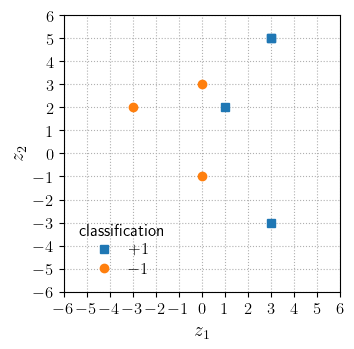


[Final Exam Problem 11]
The second-order polynomial hard margin support machine (SVM) uses
  - cvxopt.solvers.qp: 5 support vectors;
  - sklearn.svm.SVC: 5 support vectors.


In [4]:
x = np.array(((1, 0), (0, 1), (0, -1), (-1, 0), (0, 2), (0, -2), (-2, 0)), 
             dtype=float)
y = np.array((-1, -1, -1, 1, 1, 1, 1), dtype=float)
z = np.hstack((x[:, 1:] ** 2 - 2 * x[:, :1] - 1, 
               x[:, :1] ** 2 - 2 * x[:, 1:] + 1))

ticks = np.arange(-6, 7)
_, ax = plt.subplots()
ax.plot(*z[y == 1].T, "s", label="$+1$")
ax.plot(*z[y == -1].T, "o", label="$-1$")
ax.grid(ls=":")
ax.legend(title="classification", loc="lower left")
ax.set_aspect("equal", "box")
ax.set_xlabel("$z_1$")
ax.set_xlim(-6, 6)
ax.set_xticks(ticks)
ax.set_ylabel("$z_2$")
ax.set_ylim(-6, 6)
ax.set_yticks(ticks)
plt.show()

solvers.options["show_progress"] = False
solution = solvers.qp(matrix(np.outer(y, y) * (1 + x @ x.T) ** 2),
                      matrix(-np.ones((x.shape[0], 1))), 
                      matrix(-np.eye(x.shape[0])), 
                      matrix(np.zeros(x.shape[0])), 
                      matrix(y[None]), 
                      matrix(0.0))

clf = svm.SVC(C=np.finfo(float).max, kernel="poly", degree=2, gamma=1, 
              coef0=1)
clf.fit(x, y)

print("\n[Final Exam Problem 11]\n"
      "The second-order polynomial hard margin support machine "
      "(SVM) uses\n  - cvxopt.solvers.qp: "
      f"{(np.array(solution['x']) > 1e-6).sum()} support vectors;\n"
      f"  - sklearn.svm.SVC: {clf.n_support_.sum()} support vectors.")

### Problems 13–18

In [5]:
N_runs = 100
N_train = 100
N_test = 1_000
columns = ["gamma", "K", "nonseparable data (kernel)", 
           "regular > kernel", "no in-sample error (regular)", 
           "in-sample error", "out-of-sample error"]
df = pd.DataFrame(columns=columns)
for gamma, K in [(1.5, 9), (1.5, 12), (2, 9)]:
    clf = svm.SVC(C=np.finfo(float).max, gamma=gamma)
    rbf = RBFRegular(gamma, K, vf=validate_binary)
    counters = np.zeros(5, dtype=float) 
    for _ in range(N_runs):
        x_train, y_train = generate_data(N_train, target_function_final_exam, 
                                         rng=rng)
        x_test, y_test = generate_data(N_test, target_function_final_exam, 
                                       rng=rng)
        clf.fit(x_train, y_train)
        if not np.isclose(clf.score(x_train, y_train), 1):
            counters[0] += 1
            continue
        E_in = rbf.train(x_train, y_train)
        E_out = rbf.get_error(x_test, y_test)
        counters[1:5] += (1 - clf.score(x_test, y_test) < E_out, E_in == 0, 
                          E_in, E_out)
    counters /= N_runs
    df.loc[len(df)] = gamma, K, *counters
(df.style.format({"gamma": "{:.1f}", "K": "{:.0f}"})
         .format("{:.0%}", subset=columns[2:5])
         .hide(axis="index")
         .set_caption(f"Radial basis function model ({N_runs:,} runs)"))

gamma,K,nonseparable data (kernel),regular > kernel,no in-sample error (regular),in-sample error,out-of-sample error
1.5,9,0%,78%,4%,0.028900,0.045830
1.5,12,0%,77%,17%,0.018300,0.043120
2.0,9,0%,82%,3%,0.030200,0.050870
